In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
train_df = pd.read_csv("train_clean.csv", index_col=[0])
test_df = pd.read_csv("test_clean.csv", index_col=[0])
train_df['target'].replace({"Job-Seekers": 1,
                            "Non Job-Seekers" : 0}, inplace = True)

## Model Training

>Before our model training part, we still needs encode the categorical variables in our dataset so that we can input it in our algorithm

In [37]:
df = train_df.copy()

<b> One Hot encoding on Gender attribute </b>

In [38]:
df = df.join(pd.get_dummies(df['gender']))
df.drop(columns = 'gender', inplace = True)

test_df = test_df.join(pd.get_dummies(test_df['gender']))
test_df.drop(columns = 'gender', inplace = True)

<b> Encoding on experience </b>

- Has relevant experience : 1
- No relevent experience : 0

In [39]:
df['relevent_experience'].replace({"Has relevent experience": 1, "No relevent experience" : 0}, inplace = True)
test_df['relevent_experience'].replace({"Has relevent experience": 1, "No relevent experience" : 0}, inplace = True)

<b> Encoding on enrolled university </b>

- Full time course : 2
- Part time course : 1
- no_enrollment : 0

In [40]:
df['enrolled_university'].replace({"no_enrollment": 0,
                                   "Part time course" : 1,
                                   "Full time course" : 2}, inplace = True)

test_df['enrolled_university'].replace({"no_enrollment": 0,
                                   "Part time course" : 1,
                                   "Full time course" : 2}, inplace = True)

<b>Encoding education_level </b>

- Phd : 4
- Masters : 3
- Graduate : 2
- High School : 1
- Primary School : 0

In [41]:
df['education_level'].replace({"Phd" : 4,
                            "Masters" : 3,
                            "Graduate" : 2,
                            "High School" : 1,
                            "Primary School" : 0}, inplace = True)

test_df['education_level'].replace({"Phd" : 4,
                            "Masters" : 3,
                            "Graduate" : 2,
                            "High School" : 1,
                            "Primary School" : 0}, inplace = True)

<b> One Hot encoding on Major Discipline </b>

In [42]:
df = df.join(pd.get_dummies(df['major_discipline'], prefix = "Major"))
df.drop(columns = 'major_discipline', inplace = True)

test_df = test_df.join(pd.get_dummies(test_df['major_discipline'], prefix = "Major"))
test_df.drop(columns = 'major_discipline', inplace = True)

<b>Encoding experience </b>

> Differenct to the previous encoding work, we just need to encode the `<1` and `>20`. Here I use to replace `<1` with 0 and `>20` with 21 and then convert the datafram to int

In [43]:
df['experience'].replace({"<1" : 0,
                          ">20" : 21}, inplace = True)

df['experience'] = df['experience'].astype("int")

test_df['experience'].replace({"<1" : 0,
                          ">20" : 21}, inplace = True)

test_df['experience'] = df['experience'].astype("int")

<b> Feature engineering on company size and company type </b>

> Company Size and Company type we both adding a missing indicator. We will use label encoding on company size and one hot encoding on company type. We can see there are levels for company size but might not be true to have this level for company type

In [44]:
df['company_size'].replace({"10/49" : "10-49"}, inplace = True)
df['company_size'].unique()

test_df['company_size'].replace({"10/49" : "10-49"}, inplace = True)
test_df['company_size'].unique()

array(['<10', 'Missing', '10-49', '10000+', '100-499', 'No company',
       '1000-4999', '50-99', '500-999', '5000-9999'], dtype=object)

In [67]:
df['company_size'].replace({"Missing" : 0,
                            "No company" : 0,
                            "<10" : 1,
                            "10-49" : 2,
                            "50-99" : 3,
                            "100-499" : 4,
                            "500-999" : 5,
                            "1000-4999" : 6,
                            "5000-9999" : 7,
                            "10000+" : 8}, inplace=True)

df = df.join(pd.get_dummies(df['company_type'], prefix = "Company_type"))
df.drop(columns='company_type', inplace = True)

test_df['company_size'].replace({"Missing" : 0,
                            "No company" : 0,
                            "<10" : 1,
                            "10-49" : 2,
                            "50-99" : 3,
                            "100-499" : 4,
                            "500-999" : 5,
                            "1000-4999" : 6,
                            "5000-9999" : 7,
                            "10000+" : 8}, inplace=True)

test_df = test_df.join(pd.get_dummies(test_df['company_type'], prefix = "Company_type"))
test_df.drop(columns='company_type', inplace = True)

<b>Encoding Last new job </b>


- Similar to experience, we use 0 to replace `never` and use 5 to replace `>4`

In [46]:
df['last_new_job'].replace({"never" : 0,
                          ">4" : 5}, inplace = True)

df['last_new_job'] = df['last_new_job'].astype("int")

test_df['last_new_job'].replace({"never" : 0,
                          ">4" : 5}, inplace = True)

test_df['last_new_job'] = df['last_new_job'].astype("int")

<b> Imbalanced Dataset </b>


> We actually can see from our dataset that the target values has a very imbalanced distribution. This might cause our algorithm to be heavily biased. Let's see what we can do to avoid this or fix the problem

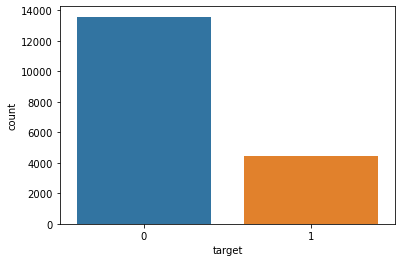

In [47]:
g = sns.countplot(x = 'target', data = df)
#g.set_xticklabels(["Not looking for job change", "Looking for job change"], fontsize = 12)

<b> Using RandomForest Classifiers </b>

Usually trees will perform well on imbalanced dataset. Thus, this can allow both of the classes being addressed

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score


X = df.drop(columns = 'target')
y = df['target']
skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier()
#We care about the True negative rate because we wonder if the algorithm will biased
# against the 1 values because not too many people are looking for jobs
tpr_list = []
acc_list = []
f1_list = []
roc_auc_list = []
#recall_list = []

for train, val in skf.split(X, y):
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_val, y_val = X.iloc[val], y.iloc[val]
    rf.fit(X_train, y_train)
    con_mat = confusion_matrix(y_val, rf.predict(X_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(rf.score(X_val, y_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))
    #recall_list.append(recall_score(y_val , rf.predict(X_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))
#print("The average recall score is: {}".format((sum(recall_list)/len(recall_list))))

The average true positive rate is: 0.46680662449955446
The average accuracy is: 0.7860037243993876
The average f1_score is: 0.516933998614588
The average roc auc score is: 0.6782773280405213


<b>Using weighted SVM to penalized the biased dataset </b>
<br>

Seems Like the RandomForest failed to differentiate the 1 and 0 in the target. We can see the true negative rate is much lower than the average accuracy. Let's try to use SVM and set the weighted = `balanced` so that the SVM can be penalized when all predicting 0

In [49]:
from sklearn.svm import SVC
svm = SVC(class_weight='balanced')

tpr_list = []
acc_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X, y):
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_val, y_val = X.iloc[val], y.iloc[val]
    svm.fit(X_train, y_train)
    con_mat = confusion_matrix(y_val, svm.predict(X_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    #tnr_list.append((con_mat[1,1] + con_mat[0,0]) / (con_mat[0,0] + con_mat[0,1] + con_mat[1,0] + con_mat[1,1]))
    acc_list.append(svm.score(X_val, y_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.6224782551752298
The average accuracy is: 0.6288147331395402
The average f1_score is: 0.9022799936121275
The average roc auc score is: 0.9346051225847416


The tpr and accuracy for SVM is quite the same but we see that the accuracy is quite low. So it might not be the optimal model for our dataset

---
<b> Under sampling </b>
<br>
We can try to first balanced our dataset and then feed the dataset into trees

First using `Random under sampling` technique to balance the dataset

<AxesSubplot:xlabel='target', ylabel='count'>

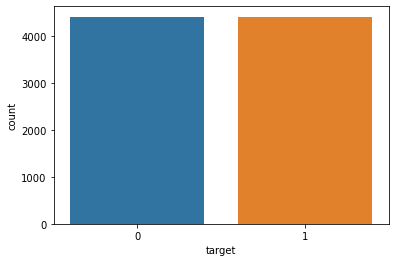

In [50]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)

X_rus, y_rus = rus.fit_resample(X, y)
sns.countplot(x = y_rus)

In [51]:
tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_rus, y_rus):
    X_rus_train, y_rus_train = X_rus.iloc[train], y_rus.iloc[train]
    X_rus_val, y_rus_val = X_rus.iloc[val], y_rus.iloc[val]
    rf.fit(X_rus_train, y_rus_train)
    con_mat = confusion_matrix(y_rus_val, rf.predict(X_rus_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(rf.score(X_rus_val, y_rus_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))
    #recall_list.append(recall_score(y_rus_val , rf.predict(X_rus_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_rus is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.742579024814909
The average accuracy_rus is: 0.7788358640868273
The average f1_score is: 0.7437129644416061
The average roc auc score is: 0.877375108118849


<b> Another under sampling technique </b>
<br>
Apart from random under sampling, we can apply some strategy on how we sample our data. We can try to use `Near Miss` which resample the data by distance

<AxesSubplot:xlabel='target', ylabel='count'>

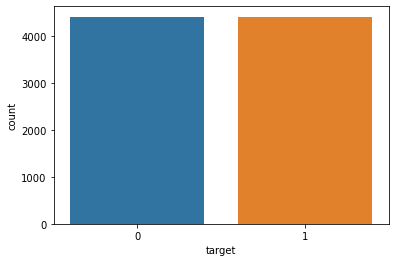

In [52]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_nm, y_nm = nm.fit_resample(X, y)
sns.countplot(x = y_nm)

In [53]:
tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_nm, y_nm):
    X_nm_train, y_nm_train = X_nm.iloc[train], y_nm.iloc[train]
    X_nm_val, y_nm_val = X_nm.iloc[val], y_nm.iloc[val]
    rf.fit(X_nm_train, y_nm_train)
    con_mat = confusion_matrix(y_nm_val, rf.predict(X_nm_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(rf.score(X_nm_val, y_nm_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))
    #recall_list.append(recall_score(y_nm_val , rf.predict(X_nm_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_nm is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.7473332254759207
The average accuracy_nm is: 0.7158475323950351
The average f1_score is: 0.5872951249719914
The average roc auc score is: 0.7668016691212567


We can see the balanced dataset performs a lot better. And seems `Random Under Sampling` is the better strategy to resampling the dataset

---

<b> Over sampling </b>

Despite the under sampling, we can also try to over sample the dataset, which means to make the minority class to the same shape of the majority class. Let's first try `Random Over Sampling`

<AxesSubplot:xlabel='target', ylabel='count'>

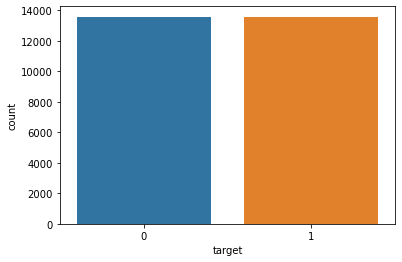

In [54]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)
sns.countplot(x = y_ros)

In [55]:
tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_ros, y_ros):
    X_ros_train, y_ros_train = X_ros.iloc[train], y_ros.iloc[train]
    X_ros_val, y_ros_val = X_ros.iloc[val], y_ros.iloc[val]
    rf.fit(X_ros_train, y_ros_train)
    con_mat = confusion_matrix(y_ros_val, rf.predict(X_ros_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(rf.score(X_ros_val, y_ros_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))
    #recall_list.append(recall_score(y_ros_val , rf.predict(X_ros_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_ros is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.9763620262708945
The average accuracy_ros is: 0.9093390531474117
The average f1_score is: 0.951548321684682
The average roc auc score is: 0.9757071557145196


Another over sampling technique is called `Synthetic Minority Oversampling Technique (SMOTE)`. This method generate new data points by:
1. Picking a class as input
2. Find its knn
3. Add a point on the line that these neighbours join
4. Repeat the steps until the dataset is balanced

<AxesSubplot:xlabel='target', ylabel='count'>

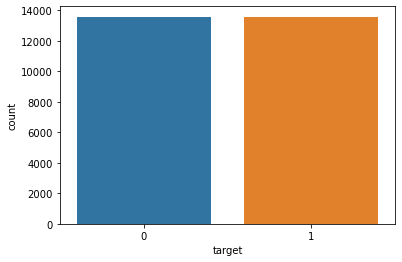

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
sns.countplot(x = y_smote)

In [57]:
tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_smote, y_smote):
    X_smote_train, y_smote_train = X_smote.iloc[train], y_smote.iloc[train]
    X_smote_val, y_smote_val = X_smote.iloc[val], y_smote.iloc[val]
    rf.fit(X_smote_train, y_smote_train)
    con_mat = confusion_matrix(y_smote_val, rf.predict(X_smote_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(rf.score(X_smote_val, y_smote_val))
    f1_list.append(f1_score(y_val, rf.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, rf.predict(X_val)))
    #recall_list.append(recall_score(y_smote_val , rf.predict(X_smote_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_smote is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.8111868010859865
The average accuracy_smote is: 0.8308347269493384
The average f1_score is: 0.9028504007583722
The average roc auc score is: 0.938987072492227


<b> `Random Over Sampling` is the best sampling technique </b>

`Random Over Sampling` has a very high accuracy, f1 score and auc score. This shows that the model tpr and fpr is good enough. <br>
<br>

> $f1 = 2 * (precision * recall) / (precision + recall)$, where recall is also known as tpr
<br>

A low f1 score means that the precision of the model is very low, this means that our model predict many false positive.

> roc auc score gives the Area under the roc curve. 
<br>

The more closer the value of the area approach 1, the better the model

---

<b> Choosing Algorithm </b>

Next, I will try a different few more algorithm and choose one with highest accuracy and tune the algorithm (Random Forest has already been used)

In [58]:
tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []
#Support Vector Machine
svm = SVC()

for train, val in skf.split(X_ros, y_ros):
    X_ros_train, y_ros_train = X_ros.iloc[train], y_ros.iloc[train]
    X_ros_val, y_ros_val = X_ros.iloc[val], y_ros.iloc[val]
    svm.fit(X_ros_train, y_ros_train)
    con_mat = confusion_matrix(y_ros_val, svm.predict(X_ros_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(svm.score(X_ros_val, y_ros_val))
    f1_list.append(f1_score(y_val, svm.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, svm.predict(X_val)))
    #recall_list.append(recall_score(y_ros_val , svm.predict(X_ros_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_ros is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.6243184783168836
The average accuracy_ros is: 0.6266385371818197
The average f1_score is: 0.45944957264178277
The average roc auc score is: 0.6344566005096196


In [59]:
from xgboost import XGBClassifier

tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

#Manually tune parameters
xgb = XGBClassifier(n_estimators=1000,
                     max_depth=10,
                     max_leaves=192,
                     eta=0.1,
                     reg_lambda=0,
                     #tree_method='hist',
                     eval_metric='logloss',
                     use_label_encoder=False,
                     random_state=1000,
                     n_jobs=-1)

for train, val in skf.split(X_ros, y_ros):
    X_ros_train, y_ros_train = X_ros.iloc[train], y_ros.iloc[train]
    X_ros_val, y_ros_val = X_ros.iloc[val], y_ros.iloc[val]
    xgb.fit(X_ros_train, y_ros_train)
    con_mat = confusion_matrix(y_ros_val, xgb.predict(X_ros_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(xgb.score(X_ros_val, y_ros_val))
    f1_list.append(f1_score(y_val, xgb.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, xgb.predict(X_val)))
    #recall_list.append(recall_score(y_ros_val , xgb.predict(X_ros_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_ros is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.974079230370738
The average accuracy_ros is: 0.9069823551536494
The average f1_score is: 0.9490722851048987
The average roc auc score is: 0.9739474483951657


In [60]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter= 1000)

tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_ros, y_ros):
    X_ros_train, y_ros_train = X_ros.iloc[train], y_ros.iloc[train]
    X_ros_val, y_ros_val = X_ros.iloc[val], y_ros.iloc[val]
    logistic.fit(X_ros_train, y_ros_train)
    con_mat = confusion_matrix(y_ros_val, logistic.predict(X_ros_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(logistic.score(X_ros_val, y_ros_val))
    f1_list.append(f1_score(y_val, logistic.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, logistic.predict(X_val)))
    #recall_list.append(recall_score(y_ros_val , logistic.predict(X_ros_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_ros is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.7493738489871087
The average accuracy_ros is: 0.7277210561525785
The average f1_score is: 0.577941856980881
The average roc auc score is: 0.7383108913668561


In [61]:
from lightgbm import LGBMClassifier
#Manually tune parameters
lgbm = LGBMClassifier(n_estimators=1000,
                     num_leaves=192,
                     max_depth=10,
                     learning_rate=0.1,
                     random_state=1000,
                     n_jobs=-1)

tpr_list = []
acc_list = []
#recall_list = []
f1_list = []
roc_auc_list = []

for train, val in skf.split(X_ros, y_ros):
    X_ros_train, y_ros_train = X_ros.iloc[train], y_ros.iloc[train]
    X_ros_val, y_ros_val = X_ros.iloc[val], y_ros.iloc[val]
    lgbm.fit(X_ros_train, y_ros_train)
    con_mat = confusion_matrix(y_ros_val, lgbm.predict(X_ros_val))
    tpr_list.append((con_mat[1,1]) / (con_mat[1,1] + con_mat[1,0]))
    acc_list.append(lgbm.score(X_ros_val, y_ros_val))
    f1_list.append(f1_score(y_val, lgbm.predict(X_val)))
    roc_auc_list.append(roc_auc_score(y_val, lgbm.predict(X_val)))
    #recall_list.append(recall_score(y_ros_val , lgbm.predict(X_ros_val)))

    
print("The average true positive rate is: {}".format((sum(tpr_list)/len(tpr_list))))
print("The average accuracy_ros is: {}".format((sum(acc_list)/len(acc_list))))
print("The average f1_score is: {}".format((sum(f1_list)/len(f1_list))))
print("The average roc auc score is: {}".format((sum(roc_auc_list)/len(roc_auc_list))))

The average true positive rate is: 0.9738583986308541
The average accuracy_ros is: 0.9070191536667401
The average f1_score is: 0.9491220956324762
The average roc auc score is: 0.973711924632396


---
<b>Model representation and summary </b>

In [62]:
from sklearn.model_selection import train_test_split

model = {'Random Forest': rf, "Light Gradient Boost" : lgbm, "XGBoost" : xgb}
X_ros_train, X_ros_val, y_ros_train, y_ros_val = train_test_split(X_ros, y_ros, random_state = 42)

for i in model.keys():
    model[i].fit(X_ros_train, y_ros_train)
    print(i)
    print("--------------")
    print("Accuracy: ", model[i].score(X_ros_val, y_ros_val))
    print("True positive rate: ", recall_score(y_ros_val, model[i].predict(X_ros_val)))
    print("F1 score: ", f1_score(y_ros_val, model[i].predict(X_ros_val)))
    print("Roc auc score: ", roc_auc_score(y_ros_val, model[i].predict(X_ros_val)))
    print("--------------")
    print("\n")

Random Forest
--------------
Accuracy:  0.8960082486375018
True positive rate:  0.960166468489893
F1 score:  0.9014792073681273
Roc auc score:  0.89657958460991
--------------


Light Gradient Boost
--------------
Accuracy:  0.8898217705111209
True positive rate:  0.9488703923900119
F1 score:  0.8951205832865957
Roc auc score:  0.8903476049541301
--------------


XGBoost
--------------
Accuracy:  0.8895271763146266
True positive rate:  0.9482758620689655
F1 score:  0.8948106591865358
Roc auc score:  0.8900503397936068
--------------




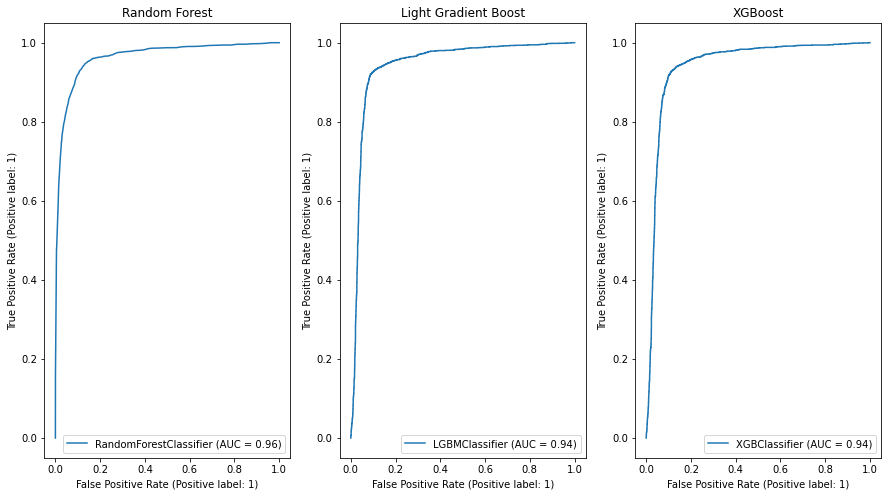

In [63]:
from sklearn.metrics import plot_roc_curve
import warnings
warnings.filterwarnings("ignore")
f, ax = plt.subplots(1,3, figsize = (15,8))
axis = 0
for key, values in model.items():
    plot_roc_curve(values, X_ros_val, y_ros_val, ax = ax[axis])
    ax[axis].set_title(key)
    axis = axis + 1

<b> Predicting our test dataset to apply in real life </b>

In [68]:
test_df['target'] = xgb.predict(test_df)

In [69]:
#test dataframe now contains the target columns
test_df

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,Female,Male,...,Major_STEM,Company_type_Early Stage Startup,Company_type_Funded Startup,Company_type_Missing,Company_type_NGO,Company_type_No company,Company_type_Other,Company_type_Public Sector,Company_type_Pvt Ltd,target
0,0.827,1,2,2,21.0,1,1.0,21,0,1,...,1,0,0,1,0,0,0,0,0,0
1,0.920,1,0,2,15.0,0,5.0,98,1,0,...,1,0,0,0,0,0,0,0,1,1
2,0.624,0,0,1,5.0,0,0.0,15,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0.827,1,0,3,NaN,2,NaN,39,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.920,1,0,2,21.0,8,4.0,72,0,1,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,0.920,0,0,2,3.0,0,0.0,15,0,1,...,0,0,0,0,0,0,0,1,0,1
2125,0.897,1,0,3,8.0,0,1.0,30,0,1,...,1,0,0,1,0,0,0,0,0,0
2126,0.887,0,0,0,0.0,0,1.0,18,0,1,...,0,0,0,0,0,0,0,0,1,0
2127,0.804,1,2,1,11.0,4,1.0,84,0,1,...,0,0,0,0,0,0,0,1,0,0


<AxesSubplot:xlabel='target', ylabel='count'>

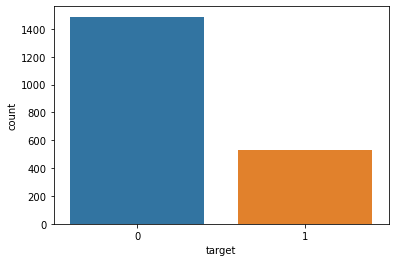

In [70]:
sns.countplot(x = 'target', data = test_df)

The predicted dataset is also imbalanced. Great! This shows that our model will also working in real life. We can trust the accuracy will be approximately the same produced by our validation set